### States

1) Average Delivery Days per State
2) Box Plot to Find Long Tails
3) Rank by Regions
4) Distance-Normalized Performance (Efficiency Score)
5) Finding Area of Foucs (which state need detail analysis)
6) The "Regional Sunday" Interaction

In [1]:
import pandas as pd
import h3

# for drawing map
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import read_customer_seller, add_brazil_geometry, plot_performance, read_state_name_lookup

In [2]:
df = read_customer_seller()

In [3]:
df.head()

,order_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,cus_state,cus_lat,cus_lng,seller_state,seller_lat,seller_lng
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,SP,-23.574809,-46.587471,SP,-23.680114,-46.452454
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,BA,-12.169860,-44.988369,SP,-19.810119,-43.984727
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,GO,-16.746337,-48.514624,SP,-21.362358,-48.232976
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,RN,-5.767733,-35.275467,MG,-19.840168,-43.923299
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,SP,-23.675037,-46.524784,SP,-23.551707,-46.260979


In [4]:
df['delivery_hours'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.total_seconds() / 3600


#### 1) Average Delivery Days per State

In [5]:
gp = df.groupby('cus_state')['delivery_hours'].mean().reset_index()
gp.head()

,cus_state,delivery_hours
0,AC,504.857111
1,AL,588.292235
2,AM,634.223782
3,AP,652.441625
4,BA,462.721424


In [6]:
gp = add_brazil_geometry(gp, 'cus_state')
gp.head()

,UF,geometry,delivery_hours,center
0,AC,"POLYGON ((-68.61895 -11.12971, -68.68534 -11.1...",504.857111,POINT (-70.44565 -9.33281)
1,AL,"POLYGON ((-36.43149 -10.44823, -36.47339 -10.4...",588.292235,POINT (-36.61065 -9.50338)
2,AP,"MULTIPOLYGON (((-51.90932 -1.16579, -51.96526 ...",652.441625,POINT (-51.9383 1.44925)
3,AM,"POLYGON ((-63.47887 2.19845, -63.43955 2.09251...",634.223782,POINT (-64.66208 -4.2071)
4,BA,"MULTIPOLYGON (((-45.95923 -14.89726, -45.93537...",462.721424,POINT (-41.66166 -12.49308)


In [7]:
gp.shape

(27, 4)

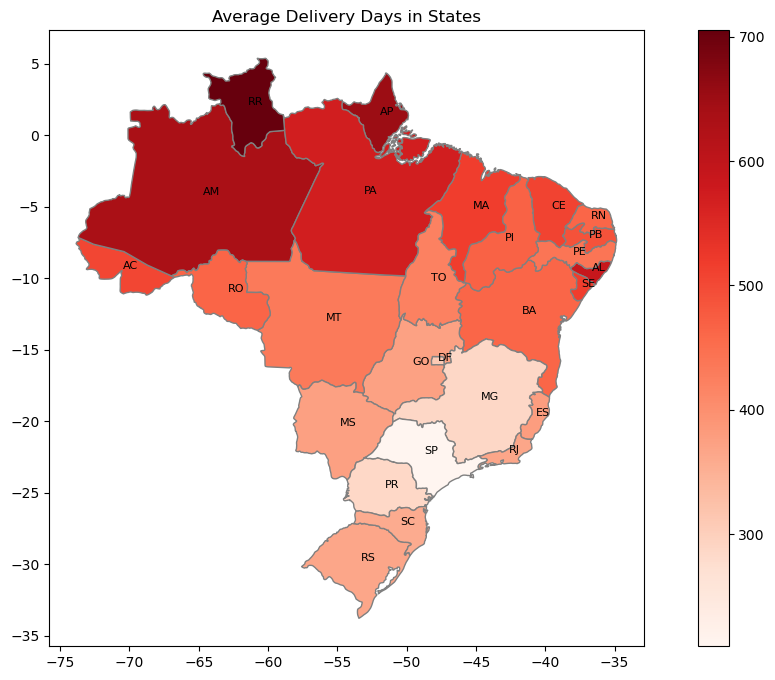

In [8]:
plot_performance(gp, 'delivery_hours', 'Average Delivery Days in States', cmap = "Reds")

#### 2) Box Plot to Find Tails

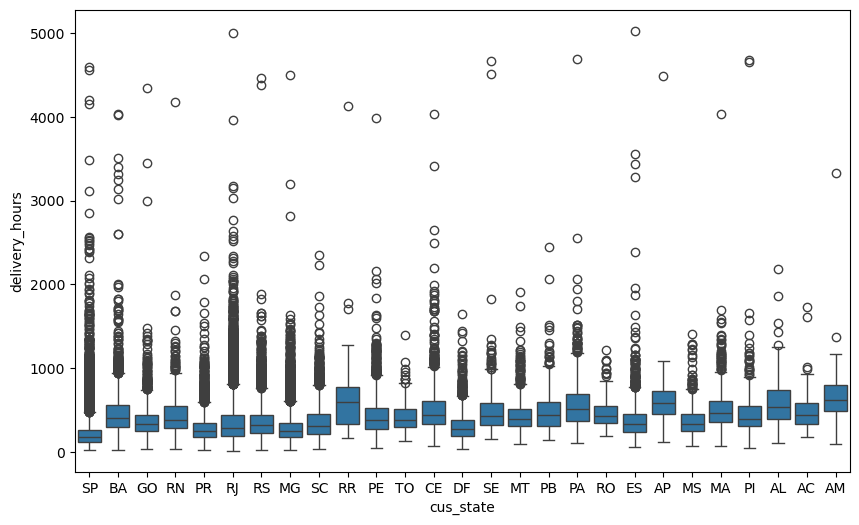

In [9]:
fig, ax = plt.subplots(figsize=(10, 6)) #

sns.boxplot(x="cus_state", y="delivery_hours", data=df, ax = ax)
plt.show()

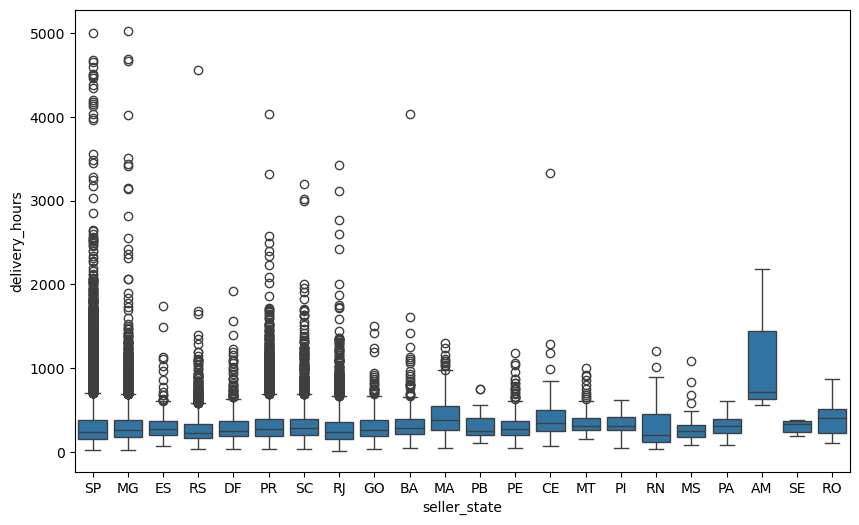

In [10]:
fig, ax = plt.subplots(figsize=(10, 6)) #

sns.boxplot(x="seller_state", y="delivery_hours", data=df, ax = ax)
plt.show()

#### Finding
Regardless of the states, there are a lot of long tails deliveries.

#### 3) Encode to Find Performance Region Wide
Instead of 27 states, we will use Region for better performance with Regression.


In [11]:
regions = read_state_name_lookup()

In [12]:
regions.head()

,0,1,2,3,4,5,6,7,8,9
0,BR,Brazil\n(entire country),Brasília,-,"8,514,204\n(slightly larger than\nthe Continen...","192,000,000(2008\nestimate)",82.5/17.5,"5,564","R$8,300",72.24
1,Common\nTwo Letter\nAbbreviation,State,Capitol\nCity,Region,Size\n(in km²),Population\n(2007 estimate),%\nPop.\nUrban/Rural,Number\nof Municipal Districts,Per\nCapita GNP in Reais (R$),Life\nExpectancy\n(2007 projection)
2,AC,Acre,Rio Branco,North,"152,581","664,000",69.6/30.4,24,"R$5,413",71.1
3,AL,Alagoas,Maceió,Northeast,"27,767","3,557,000",67.4/32.6,102,"R$3,876",65.4
4,AP,Amapá,Macapá,North,"142,814","619,000",93.7/6.3,16,"R$6,796",70.1


In [13]:
merge = pd.merge(df, regions[["0", "3"]], left_on = "cus_state", right_on = "0", how="left")
merge.head()

,order_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,cus_state,cus_lat,cus_lng,seller_state,seller_lat,seller_lng,delivery_hours,0,3
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,SP,-23.574809,-46.587471,SP,-23.680114,-46.452454,202.477778,SP,Southeast
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,BA,-12.169860,-44.988369,SP,-19.810119,-43.984727,330.768889,BA,Northeast
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,GO,-16.746337,-48.514624,SP,-21.362358,-48.232976,225.461111,GO,Center\nWest
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,RN,-5.767733,-35.275467,MG,-19.840168,-43.923299,317.010000,RN,Northeast
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,SP,-23.675037,-46.524784,SP,-23.551707,-46.260979,68.973056,SP,Southeast


In [14]:
df = merge

In [15]:
gp = df.groupby("3")["delivery_hours"].mean().reset_index()
gp = gp.sort_values(by="delivery_hours")
gp.head()

,3,delivery_hours
4,Southeast,257.252848
3,South,336.033696
0,Center\nWest,359.508125
2,Northeast,479.081196
1,North,541.426335


#### 4) Distance-Normalized Performance (Efficiency Score)

In [16]:
df.head()

,order_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,cus_state,cus_lat,cus_lng,seller_state,seller_lat,seller_lng,delivery_hours,0,3
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,SP,-23.574809,-46.587471,SP,-23.680114,-46.452454,202.477778,SP,Southeast
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,BA,-12.169860,-44.988369,SP,-19.810119,-43.984727,330.768889,BA,Northeast
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,GO,-16.746337,-48.514624,SP,-21.362358,-48.232976,225.461111,GO,Center\nWest
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,RN,-5.767733,-35.275467,MG,-19.840168,-43.923299,317.010000,RN,Northeast
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,SP,-23.675037,-46.524784,SP,-23.551707,-46.260979,68.973056,SP,Southeast


In [17]:
df['dist'] = df.apply(lambda row: h3.great_circle_distance((row['cus_lat'], row['cus_lng']), (row['seller_lat'], row['seller_lng'])), axis=1)
df['velocity'] = df['dist'] / df['delivery_hours']

In [20]:
gp = df.groupby("3")["velocity"].mean().reset_index()
gp = gp.sort_values(by="velocity", ascending=False)
gp.head()

,3,velocity
1,North,5.160205
2,Northeast,4.641585
0,Center\nWest,3.046895
3,South,2.333016
4,Southeast,1.625049


#### Finding 
South, Southeast seems faster than the other regions, but they are the least efficent ones.

#### 5) Finding Area of Foucs (which state need detail analysis)

In [55]:
gp1 = df.groupby("cus_state")["velocity"].mean().reset_index()
gp1 = gp1.sort_values(by="velocity")
gp1.head()

,cus_state,velocity
25,SP,1.340665
18,RJ,1.792393
23,SC,1.931180
17,PR,2.030966
10,MG,2.279754


In [56]:
gp1[gp1['cus_state'] == 'PA']

,cus_state,velocity
13,PA,5.139955


In [35]:
gp2 = df.groupby("cus_state")["order_id"].nunique().reset_index()
gp2 = gp2.sort_values(by="order_id", ascending=False)
gp2.head()

,cus_state,order_id
25,SP,40448
18,RJ,12331
10,MG,11332
22,RS,5328
17,PR,4912


In [36]:
gp1['total_orders'] = gp2['order_id']
gp1.head()

,cus_state,velocity,total_orders
25,SP,1.340665,40448
18,RJ,1.792393,12331
23,SC,1.931180,3536
17,PR,2.030966,4912
10,MG,2.279754,11332


In [39]:
gp1[['velocity', 'total_orders']].corr()

,velocity,total_orders
velocity,1.000000,-0.559785
total_orders,-0.559785,1.000000


#### Finding 
There is a strong negative correlation between velociyt and total_orders. The carrier are having difficulities with handling large number of orders.

#### 6) The "Regional Sunday" Interaction

In [46]:
df['delivered_carrier_day'] = df['order_delivered_carrier_date'].dt.day_name()
df2 = df[['delivered_carrier_day', 'cus_state', 'delivery_hours']]

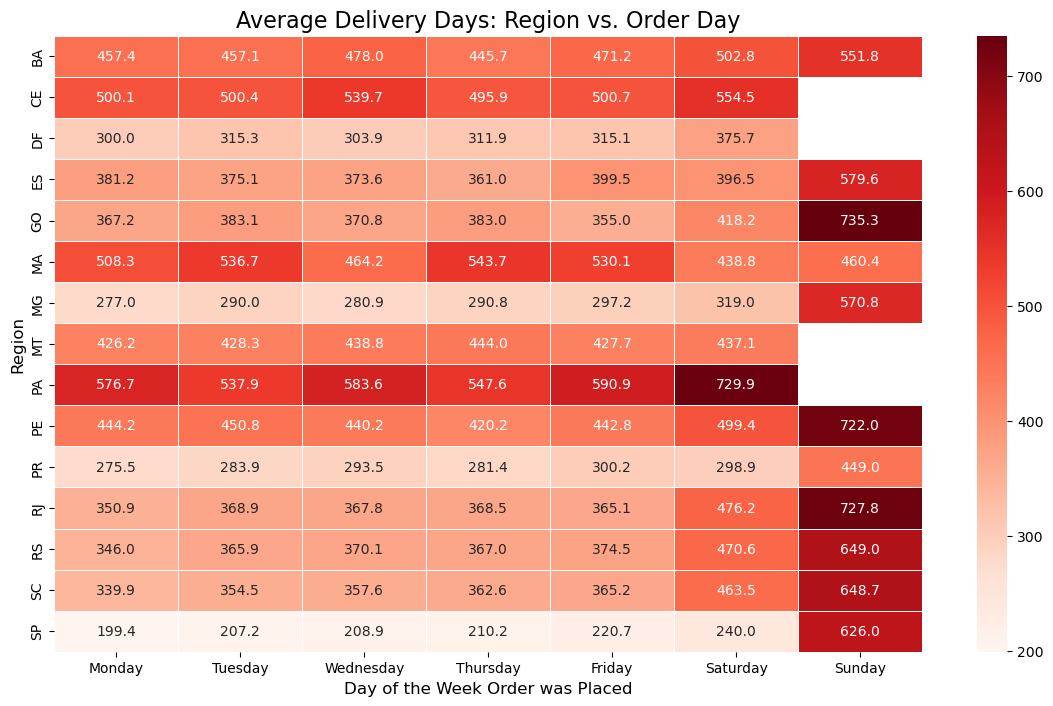

In [60]:
# 2. Define the correct order for days of the week for the plot axes
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# 3. Filter for the Top 15 Regions by volume (to keep the heatmap readable)
top_regions = df['cus_state'].value_counts().nlargest(15).index
df_filtered = df[df['cus_state'].isin(top_regions)]

# 4. Create a Pivot Table: Rows = Regions, Columns = Day of Week, Values = Mean Delivery Time
pivot_table = df_filtered.pivot_table(
    values='delivery_hours', 
    index='cus_state', 
    columns='delivered_carrier_day', 
    aggfunc='mean'
)

# 5. Reorder columns to follow the calendar week
pivot_table = pivot_table[day_order]

# 6. Plotting the Heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, annot=True, cmap='Reds', fmt='.1f', linewidths=.5)

plt.title('Average Delivery Days: Region vs. Order Day', fontsize=16)
plt.xlabel('Day of the Week Order was Placed', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.show()

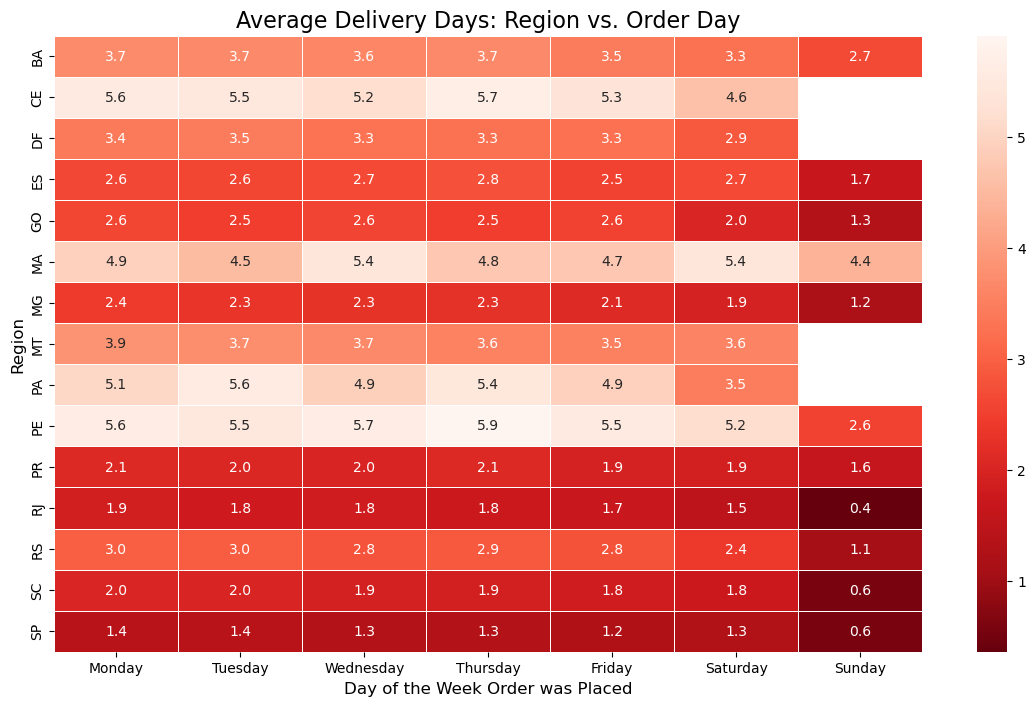

In [59]:
# 2. Define the correct order for days of the week for the plot axes
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# 3. Filter for the Top 15 Regions by volume (to keep the heatmap readable)
top_regions = df['cus_state'].value_counts().nlargest(15).index
df_filtered = df[df['cus_state'].isin(top_regions)]

# 4. Create a Pivot Table: Rows = Regions, Columns = Day of Week, Values = Mean Delivery Time
pivot_table = df_filtered.pivot_table(
    values='velocity', 
    index='cus_state', 
    columns='delivered_carrier_day', 
    aggfunc='mean'
)

# 5. Reorder columns to follow the calendar week
pivot_table = pivot_table[day_order]

# 6. Plotting the Heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, annot=True, cmap='Reds_r', fmt='.1f', linewidths=.5)

plt.title('Average Delivery Days: Region vs. Order Day', fontsize=16)
plt.xlabel('Day of the Week Order was Placed', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.show()

### Interpretation
How to Interpret the Results for your Project
Vertical "Red" Stripes: If the "Sunday" column is dark red across all regions, the root cause is Centralized (e.g., your main warehouse doesn't process weekend orders).

Horizontal "Red" Stripes: If a specific region is dark red across all days, that region has a Local Infrastructure problem (e.g., it's very far or the local carrier is slow).

Isolated "Dark Squares": If only specific regions turn red on Sundays, those regions have a Regional Weekend Gap. This is where you should tell the business to change their local carrier or hub staff for those specific zones.